In [1]:
import pickle
import pandas as pd
import scanpy as sc
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
metric_all = []
for dataset in ['dixit', 'adamson', 'k562', 'rpe1']:
    folder = dataset if dataset in ['dixit', 'adamson', 'norman'] else f'replogle_{dataset}_essential'
    adata = sc.read_h5ad(f"../../data/Data_GEARS/{folder}/perturb_processed.h5ad")
    ls_scouter = []
    ls_baseline = []
    n_split = 5 if dataset != 'dixit' else 10
    for split in range(1, n_split+1):
        print(f'{dataset}: {split}')
        result_split = pickle.load(open(f"../../results/Scouter/Scouter_{dataset}_{split}.pkl", "rb"))
        test_conds = list(result_split.keys())
        train_adata = adata[~adata.obs.condition.isin(test_conds)]
        train_df = pd.DataFrame(train_adata.X.toarray(), columns=train_adata.var.gene_name.values, index=train_adata.obs_names)
        train_X = train_df.mean().values
        
        metric_scouter = {'NormMSE':{}, 'Pearson':{}}
        metric_baseline = {'NormMSE':{}, 'Pearson':{}}
        for cond, result in result_split.items():
            DE_idx = result['DE_idx']
            DE_name = result['DE_name']
            
            ctrl = pd.DataFrame(result['Ctrl'], columns=DE_name).mean(axis=0)
            true = pd.DataFrame(result['Truth'], columns=DE_name).mean(axis=0)
            scouter = pd.DataFrame(result['Pred'], columns=DE_name).mean(axis=0)
            baseline = train_X[DE_idx]

            mse_scouter = mse(true, scouter)/mse(true, ctrl)
            ppc_scouter = pearsonr(true-ctrl, scouter-ctrl)[0]
            
            mse_baseline = mse(true, baseline)/mse(true, ctrl)
            ppc_baseline = pearsonr(true-ctrl, baseline-ctrl)[0]

            metric_scouter['NormMSE'][cond] = mse_scouter
            metric_scouter['Pearson'][cond] = ppc_scouter

            metric_baseline['NormMSE'][cond] = mse_baseline
            metric_baseline['Pearson'][cond] = ppc_baseline
        metric_scouter = pd.DataFrame(metric_scouter).assign(Method='Scouter')
        metric_baseline = pd.DataFrame(metric_baseline).assign(Method='Baseline')
        ls_scouter.append(metric_scouter)
        ls_baseline.append(metric_baseline)

    metric_ds = pd.concat(ls_scouter + ls_baseline).assign(Dataset=dataset)
    metric_all.append(metric_ds)
metric_all = pd.concat(metric_all)
metric_all = metric_all.drop(columns=['Pearson']).copy()

dixit: 1
dixit: 2
dixit: 3
dixit: 4
dixit: 5
dixit: 6
dixit: 7
dixit: 8
dixit: 9
dixit: 10
adamson: 1
adamson: 2
adamson: 3
adamson: 4
adamson: 5
k562: 1
k562: 2
k562: 3
k562: 4
k562: 5
rpe1: 1
rpe1: 2
rpe1: 3
rpe1: 4
rpe1: 5


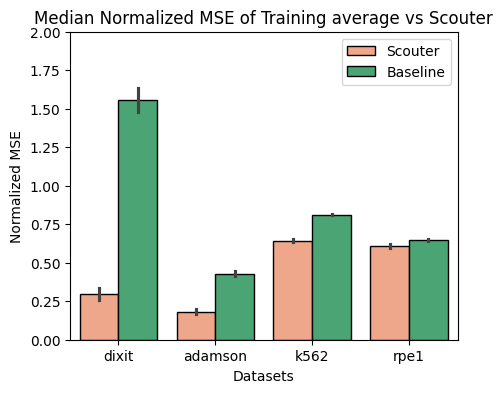

In [3]:
colors = ['lightsalmon', 'mediumseagreen']
plt.figure(figsize=(5, 4))
sns.barplot(data=metric_all, x="Dataset", y="NormMSE", hue="Method", 
            errorbar=("ci", 50), palette=colors, edgecolor="black")

plt.xlabel("Datasets")
plt.ylabel("Normalized MSE")
plt.ylim(0, 2)
plt.title("Median Normalized MSE of Training average vs Scouter")
plt.legend(title="")
plt.show()